In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import json
import time
import itertools
from scipy import stats
import psycopg2 as psql
from psycopg2.extras import RealDictCursor

import sys
sys.path.append("..")
from tools.flight_projection import *

import seaborn as sns
sns.set(color_codes=True)

try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

Unable to connect to the database.
could not connect to server: Connection refused
	Is the server running on host "localhost" (127.0.0.1) and accepting
	TCP/IP connections on port 5432?



/home/victor/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [207]:
def realign_conflict(b):
    
    cfl_dst = 9260
    
    for i in range(1,len(b)):
        
        if calc_coord_dst_simple((b['lon_1'][-i],b['lat_1'][-i]),(b['lon_2'][-i],b['lat_2'][-i])) >= cfl_dst:
            for k in ['ts_1','lat_1','lon_1','alt_1','spd_1','hdg_1','roc_1',
                      'ts_2','lat_2','lon_2','alt_2','spd_2','hdg_2','roc_2']:
                b[k] = b[k][:-(i-1)]
            return (b)
    
    return None
        

def time_to_conflict(tr1,tr2):
    
    cfl_dst = 9260
    
    for i in range(len(tr1)):
        cdst = calc_coord_dst_simple((tr1['proj_lat'].iloc[i],
                                  tr1['proj_lon'].iloc[i]),
                                 (tr2['proj_lat'].iloc[i],
                                  tr2['proj_lon'].iloc[i])) 
        print(cdst)
        if cdst <= cfl_dst:
            ttc = tr1['ts'].iloc[i] - tr1['ts'].iloc[0]
            
            return ttc
    
    return None


def ttc_est(lat_1, lon_1, lat_2, lon_2, hdg_1, hdg_2, spd_1, spd_2):
    
    knots_to_ms = 0.514444
    ipz_lim = 9260 #meters
    
    alpha_1 = heading_diff(calc_compass_bearing((lat_1, lon_1),(lat_2, lon_2)), hdg_1)
    alpha_2 = heading_diff(calc_compass_bearing((lat_2, lon_2),(lat_1, lon_1)), hdg_2)
    
    gamma = 180 - (alpha_1 + alpha_2)
    
    if gamma < 0:
        return np.nan
    else:
        dy_1 = math.cos(math.radians(heading_diff(hdg_1,0))) * spd_1 * knots_to_ms
        dy_2 = math.cos(math.radians(heading_diff(hdg_2,0))) * spd_2 * knots_to_ms
        dx_1 = math.sin(math.radians(heading_diff(hdg_1,0))) * spd_1 * knots_to_ms
        dx_2 = math.sin(math.radians(heading_diff(hdg_2,0))) * spd_2 * knots_to_ms
        
        dx = abs(dx_1 - dx_2)
        dy = abs(dy_1 - dy_2)
        
        s = calc_coord_dst((lat_1, lon_1),(lat_2, lon_2))
        ttc = (s - ipz_lim) / np.sqrt((dy**2 + dx**2))
        
        return ttc

Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in realigning Conflict
Error in reali

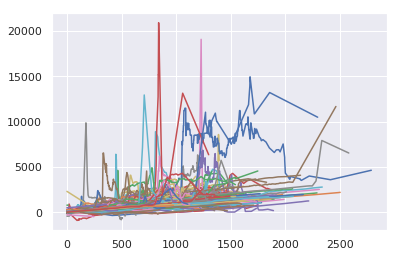

In [208]:
cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT * FROM public.conflicts;")
batch = cur_read.fetchall()

from mpl_toolkits.mplot3d import Axes3D

dim='2d'
la_time = 1200
bin_sec = 20
bin_dp_df = {}
spd_lim = 30000

# plt.figure(figsize=(30,30))

cfl_dst = 9260
for b in batch:

    try:
        b = realign_conflict(b)
    except Exception as e:
        print('Error in realigning Conflict')
        b = None
        
    if b:
        b['ettc'] = []
        b['ttc'] = []
        b['ecpa'] = []

        fl1 = pd.DataFrame()
        fl1['lat'] = b['lat_1']
        fl1['lon'] = b['lon_1']
        fl1['ts'] = b['ts_1']
        fl1['hdg'] = b['hdg_1']
        fl1['spd'] = b['spd_1']

        fl2 = pd.DataFrame()
        fl2['lat'] = b['lat_2']
        fl2['lon'] = b['lon_2']
        fl2['ts'] = b['ts_2']
        fl2['hdg'] = b['hdg_2']
        fl2['spd'] = b['spd_2']


        for t in range(len(b['ts_1'])):
            try:
                b['ttc'].append(b['ts_1'][-1] - b['ts_1'][t])
            except:
                print(b)
            b['ettc'].append(ttc_est(fl1['lat'][t], fl1['lon'][t], fl2['lat'][t], fl2['lon'][t], 
                                     fl1['hdg'][t], fl2['hdg'][t], fl1['spd'][t], fl2['spd'][t]))
        
        b['ttc_diff'] = [x-y for x,y in zip(b['ttc'],b['ettc'])]
            
            
        for tt in range(int(la_time/bin_sec)):
            bmin = tt*bin_sec
            bmax = (tt+1)*bin_sec
            if str(bmax) not in list(bin_dp_df.keys()):
                bin_dp_df[str(bmax)] = []
                
            bin_dp_df[str(bmax)].extend([e for e,t in zip(b['ttc_diff'], b['ttc']) 
                                                if t >= bmin and t <= bmax])

        plt.plot(b['ttc'], b['ettc'])
plt.show()


In [187]:
t = len(fl1['lat']) - 100
ttc_est(fl1['lat'][t], fl1['lon'][t], fl2['lat'][t], fl2['lon'][t], 
                                     fl1['hdg'][t], fl2['hdg'][t], fl1['spd'][t], fl2['spd'][t])
lat_1, lon_1, lat_2, lon_2, hdg_1, hdg_2, spd_1, spd_2 = fl1['lat'][t], fl1['lon'][t], fl2['lat'][t], fl2['lon'][t], fl1['hdg'][t], fl2['hdg'][t], fl1['spd'][t], fl2['spd'][t]

print(lat_1, lon_1, lat_2, lon_2, hdg_1, hdg_2, spd_1, spd_2)

51.63523 4.28078 51.91273 5.10262 29.1 271.3 400.0 425.0


In [192]:
knots_to_ms = 0.514444
ipz_lim = 9260 #meters
m_per_deglat = 111200
m_per_deglon = 68460
dy_1 = math.cos(math.radians(heading_diff(hdg_1,0))) * spd_1 * knots_to_ms
dy_2 = math.cos(math.radians(heading_diff(hdg_2,0))) * spd_2 * knots_to_ms
dx_1 = math.sin(math.radians(heading_diff(hdg_1,0))) * spd_1 * knots_to_ms
dx_2 = math.sin(math.radians(heading_diff(hdg_2,0))) * spd_2 * knots_to_ms

dx = abs(dx_1 - dx_2)
dy = abs(dy_1 - dy_2)

s = calc_coord_dst((lat_1, lon_1),(lat_2, lon_2))
# y = abs(lat_1 - lat_2) * m_per_deglat
# x = abs(lon_1 - lon_2) * m_per_deglon
x = math.sin(math.radians(heading_diff(calc_compass_bearing((lat_1, lon_1),(lat_2, lon_2)),0)))*s
y = math.cos(math.radians(heading_diff(calc_compass_bearing((lat_1, lon_1),(lat_2, lon_2)),0)))*s

In [200]:
# (s-ipz_lim)/np.sqrt((dy**2 + dx**2))
ds = (2*abs(x)*dx + 2*abs(y)*dy) / (2*s)
(s - ipz_lim) / ds
(s - ipz_lim) / np.sqrt((dy**2 + dx**2))
# fl2['ts'][2]
# (b['ts_2'][-1] - b['ts_2'][0])

151.75006184322987

In [106]:
(calc_coord_dst_simple((fl1['lon'][0],fl1['lat'][0]),(fl2['lon'][0],fl2['lat'][0])) - 
calc_coord_dst_simple((fl1['lon'][1],fl1['lat'][1]),(fl2['lon'][1],fl2['lat'][1])))/(fl1['ts'][1] - fl1['ts'][0])

199.1746095406823

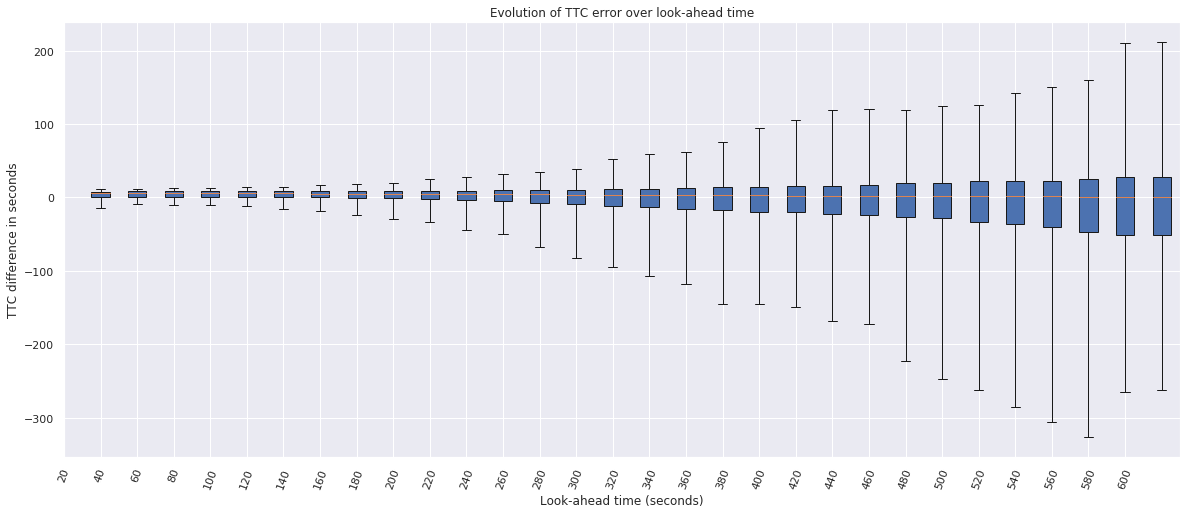

In [211]:
box_data = []

bin_df = bin_dp_df

for k in [kx for kx in bin_df.keys() if int(kx) <= 600]:
    box_data.append((int(k), [i for i in bin_df[k] if not np.isnan(i)]))
    
box_data_sort = sorted(box_data, key=lambda tup: tup[0])
box_data_2 = [i[1] for i in box_data_sort]

x = range(len(box_data_2))

plt.figure(figsize=(20,8))
plt.boxplot(box_data_2, showfliers=False, patch_artist=True, whis=[5,95])
# plt.hlines(9260, 0, 1200, colors='r', linestyles='dashed', label='IPZ limit')
# plt.hlines(-9260, 0, 1200, colors='r', linestyles='dashed')
# plt.hlines(-9260, 0, 1200, colors='r', linestyles='dashed', label='IPZ limit')
plt.xticks(x, [i[0] for i in box_data_sort])
plt.xticks(rotation=70)
plt.xlabel('Look-ahead time (seconds)')
plt.ylabel('TTC difference in seconds')
plt.title('Evolution of TTC error over look-ahead time')
# plt.legend(prop={'size': 16})
# plt.xlim((0,600))
plt.show()
        

In [8]:
cur_read.close()

In [77]:
def calc_coord_dst(lon1, lat1, lon2, lat2):
    R = 6371.1 * 1000  # Radius of the Earth in m

    [lon1, lat1, lon2, lat2] = [math.radians(l) for l in [lon1, lat1, lon2, lat2]]

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    d = R * c
    return d

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT ts_1, lat_1, lon_1, alt_1, ts_2, lat_2, lon_2, alt_2, dstd \
                 FROM public.conflicts_2 WHERE dstd < 2000 AND altd < 5000 AND td < 10 LIMIT 100;")
batch = cur_read.fetchall()

for b in batch:
    
    df1 = pd.DataFrame()
    for k in ['ts_1', 'lat_1', 'lon_1', 'alt_1']:
        df1[k.strip('_1')] = b[k]
    df2 = pd.DataFrame()
    for k in ['ts_2', 'lat_2', 'lon_2', 'alt_2']:
        df2[k.strip('_2')] = b[k]
        
    df1['ts'] = df1['ts'].astype(int)
    df2['ts'] = df2['ts'].astype(int)
    
    if df1['ts'].max() > df2['ts'].max():
        df_l = df1
        df_r = df2
        df_r['ts_n'] = df_r['ts'].astype(int)
        sfx = ('_1','_2')
    else:
        df_l = df2
        df_r = df1
        df_r['ts_n'] = df_r['ts'].astype(int)
        sfx = ('_2','_1')

    print(len(df1))
    print(len(df2))
    dfm = pd.merge_asof(df_l, df_r, on='ts', direction='nearest', tolerance=10, suffixes=sfx)


    dfm['td'] = dfm['ts']-dfm['ts_n']
    dfm = dfm.dropna(how='any')
    dfm['dstd'] = dfm.apply(lambda r: calc_coord_dst(r['lon_1'], r['lat_1'], r['lon_2'], r['lat_2']), axis=1)
    print(dfm['dstd'].iloc[-1])
    
#     fig = plt.figure(figsize=(30,30))
#     plt.scatter(dfm['lon_1'], dfm['lat_1'], s=2, alpha=0.5)
#     plt.scatter(dfm['lon_2'], dfm['lat_2'], s=2, alpha=0.5)
#     plt.show()
#     fig = plt.figure(figsize=(30,30))
#     plt.scatter(b['lon_1'], b['lat_1'], s=2, alpha=0.5)
#     plt.scatter(b['lon_2'], b['lat_2'], s=2, alpha=0.5)
#     plt.show()

538
368
27809.91774397525
537
366
33126.2168889568
641
674
6312.182281174134
327
123
27785.98713019809
1233
1030
26143.280348079803
388
503
10390.959676366112
203
213
68828.89079008454
224
163
30078.211730740346
58
908
79623.09260322918
537
407
4963.091234155729
508
386
3821.3387267319176
573
496
25173.40987923148
285
1085
48128.07178540063
337
201
28141.37521621881
424
666
242587.7965898687
422
665
243434.0991676404
800
35
84601.9514152829
997
688
106778.07237645786
250
595
31839.46399178491
219
339
40229.19392159063
85
405
26827.816239684744
556
166
12395.660984454202
459
542
35085.89321061752
457
545
35344.16856776075
498
271
14746.176146501439
492
266
17355.52850294971
305
177
7783.257344638888
265
550
38279.715388243414
154
355
34289.82212121023
578
833
3541.583329339704
844
771
19725.981963953916
154
261
33524.26288791104
214
232
30054.81790556312
1043
210
74056.72979671926
183
972
91916.90483837738
494
229
160690.84073117026
1179
430
6685.16341106983
446
65
107522.30027526418
54

In [38]:
cur_read.close()

In [204]:
conn.close()